# Maximally Diverse Subset Sampling

A quick notebook for generating subsets from a dataset, where the nearest neighbours are maximally far apart.

Has an [accompanying blog post](https://www.ivoverhoeven.com/blog/sampling-maximally-diverse-subsets/).

Saves figures as `.svg` files in the `./figures/` directory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import jaxtyping as jtyping

## Generate some points

In [2]:
rng = np.random.default_rng(610)

num_points = 500

points = rng.uniform(-1, 1, size=(500, 2))

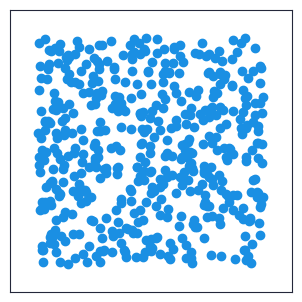

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(900 / 96, 300 / 96))

ax.scatter(
    points[:, 0],
    points[:, 1],
    color="#1a8fe3",
)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_edgecolor("#24273a")
ax.set_aspect("equal")
ax.set_xlim(-1.25, 1.25)
ax.set_ylim(-1.25, 1.25)

fig.tight_layout()

plt.show()

## Space Filling Design

In [4]:
def wsp_space_filling_design(
    min_dist: float,
    seed_point: int,
    dist_matrix: jtyping.Float[np.ndarray, " num_points num_points"],
) -> jtyping.Int[np.ndarray, " num_chosen_points"]:
    # A point should never be able to choose itself, so set diagonals to nan
    dist_matrix_ = np.copy(dist_matrix)
    np.fill_diagonal(dist_matrix_, np.nan)

    # Add the seed point to the list of chosen points
    chosen_points = [seed_point.squeeze()]

    cur_point = np.copy(seed_point)

    # Start the iterations
    while True:
        # Find all points points within a circle of radius min_dist around the current point
        points_within_circle = (dist_matrix_[cur_point, :] < min_dist).squeeze()

        # Eliminate those points from ever being chosen
        dist_matrix_[points_within_circle, :] = np.nan
        dist_matrix_[:, points_within_circle] = np.nan

        # If no points are able to be chosen, stop
        if np.all(np.isnan(dist_matrix_[cur_point, :])):
            break

        # Find the nearest neighbour that is not within that circle
        # Choose it as the next point
        nearest_outside_point = np.nanargmin(dist_matrix_[cur_point, :])

        chosen_points.append(nearest_outside_point)

        # Make sure the current point can no longer be chosen
        dist_matrix_[cur_point, :] = np.nan
        dist_matrix_[:, cur_point] = np.nan

        cur_point = nearest_outside_point

    chosen_points = np.stack(chosen_points)

    return chosen_points

In [5]:
def visualize_wsp_path(ax, points, min_dist, chosen_points):
    ax.scatter(points[:, 0], points[:, 1], marker=".", c="#1a8fe3", alpha=0.2, zorder=0)

    prev_point = None
    for point_index in np.stack(chosen_points):
        point = points[point_index]

        ax.scatter(point[0], point[1], c="#1a8fe3", zorder=2)

        if prev_point is not None:
            ax.quiver(
                prev_point[0],
                prev_point[1],
                (point[0] - prev_point[0]),
                (point[1] - prev_point[1]),
                angles="xy",
                scale_units="xy",
                scale=1,
                color="#1a8fe3",
                zorder=1,
                headwidth=7,
                headlength=9,
                headaxislength=7,
            )

        ax.add_patch(
            plt.Circle(
                (point[0], point[1]),
                min_dist / 2,
                edgecolor="#1a8fe3",
                fill=False,
                zorder=1,
            )
        )

        prev_point = point

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_edgecolor("#24273a")

    ax.set_aspect("equal")

    ax.set_xlim(-1.25, 1.25)
    ax.set_ylim(-1.25, 1.25)

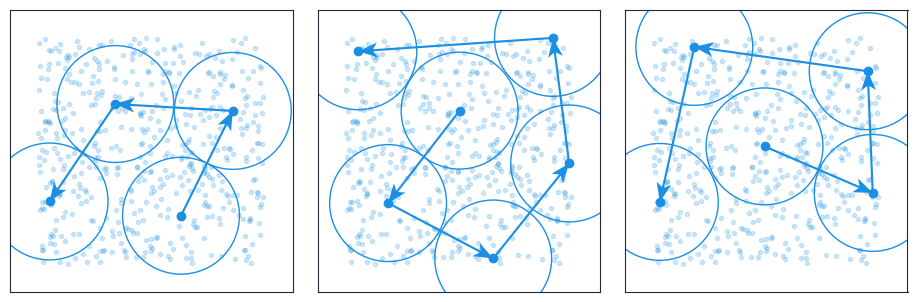

In [6]:
# Compute all pairwise distances
dist_matrix = sklearn.metrics.pairwise_distances(points)

# Find all the unique distances
unique_dists = np.unique(np.ravel(dist_matrix))[1:]

# use median dist as desired radius
min_dist = unique_dists[unique_dists.shape[0] // 2]

fig, axes = plt.subplots(1, 3, figsize=(900 / 96, 300 / 96))

# A WSP space-filling design with a random seed point
rng = np.random.default_rng(0)

chosen_points = wsp_space_filling_design(
    min_dist=min_dist,
    seed_point=rng.choice(range(points.shape[0]), size=1),
    dist_matrix=dist_matrix,
)

visualize_wsp_path(
    ax=axes[0], points=points, min_dist=min_dist, chosen_points=chosen_points
)

# Another WSP space-filling design with a different random seed point
rng = np.random.default_rng(1)

chosen_points = wsp_space_filling_design(
    min_dist=min_dist,
    seed_point=rng.choice(range(points.shape[0]), size=1),
    dist_matrix=dist_matrix,
)

# The WSP space-filling design with the centroid as seed point
visualize_wsp_path(
    ax=axes[1], points=points, min_dist=min_dist, chosen_points=chosen_points
)

mid_point = np.argmin(np.sum(np.abs(points - np.mean(points, axis=0)), axis=1), axis=0)

chosen_points = wsp_space_filling_design(
    min_dist=min_dist,
    seed_point=mid_point,
    dist_matrix=dist_matrix,
)

visualize_wsp_path(
    ax=axes[2], points=points, min_dist=min_dist, chosen_points=chosen_points
)

fig.tight_layout()

fig.savefig("figures/some_wsp_solutions.svg", transparent=True)

## Binary Search Solver

In [7]:
def binary_search_min_dist(points, desired_batch_size, verbose: bool = True):
    # Pairwise distances
    dist_matrix = sklearn.metrics.pairwise_distances(points)

    # Find all the unique distances
    unique_dists = np.unique(np.ravel(dist_matrix))[1:]

    # Define the centroid point
    # This is where we start our search
    centroid = np.argmin(
        np.sum(np.abs(points - np.mean(points, axis=0)), axis=1), axis=0
    )

    # Initiate binary search parameters
    left = 0
    right = unique_dists.shape[0] - 1

    # Binary search through all possible distances
    i = 0
    while left <= right:
        # Binary search select current distance
        middle = left + (right - left) // 2

        # Get the minimum distance
        cur_min_d = unique_dists[middle]

        chosen_points = wsp_space_filling_design(
            min_dist=cur_min_d,
            seed_point=centroid,
            dist_matrix=dist_matrix,
        )

        if verbose:
            print(f"{i:>2d} | size={len(chosen_points):d}, d={cur_min_d:.6f}")

        # If the size of the selected is too small, decrease the distance
        # Also includes infeasible (length 0) solution case
        if desired_batch_size > len(chosen_points):
            right = middle - 1

        # If too large, increase the distance
        elif desired_batch_size <= len(chosen_points):
            left = middle + 1

        i += 1

    return chosen_points, cur_min_d

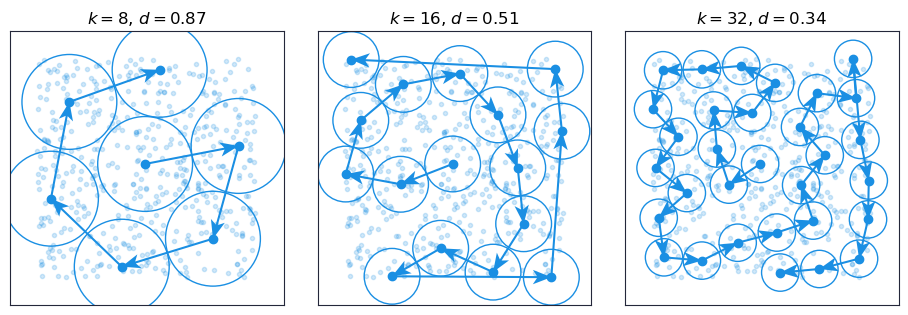

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(900 / 96, 300 / 96))

for i, batch_size in enumerate([8, 16, 32]):
    ax = axes[np.unravel_index([i], shape=(3))][0]

    chosen_points, min_dist = binary_search_min_dist(
        points,
        desired_batch_size=batch_size,
        verbose=False,
    )

    visualize_wsp_path(
        ax=ax,
        points=points,
        min_dist=min_dist,
        chosen_points=chosen_points,
    )

    ax.set_title(f"$k={batch_size}$, $d={min_dist:.2f}$")

fig.tight_layout()

fig.savefig("figures/binary_search_solutions.svg", transparent=True)

## Initial Figure

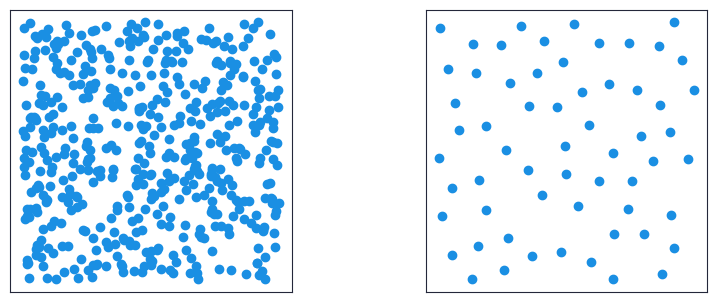

In [9]:
chosen_points, min_dist = binary_search_min_dist(
    points, desired_batch_size=64, verbose=False
)

fig, axes = plt.subplots(1, 2, figsize=(900 / 96, 300 / 96))

axes[0].scatter(points[:, 0], points[:, 1], c="#1a8fe3")

chosen_points_coords = points[chosen_points]

axes[1].scatter(chosen_points_coords[:, 0], chosen_points_coords[:, 1], c="#1a8fe3")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_edgecolor("#24273a")

    ax.set_aspect("equal")

fig.tight_layout()

plt.show()

fig.savefig("./figures/some_points.svg", transparent=True)